# General Analysis on US accidents

## Analyze with respect to impact on time distribution and weather condition

### Import Libraries

In [1]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from adjustText import adjust_text

#Import our functions
import src.import_data as iD
import src.poverty_calculations as pc
from src.which_day import which_day
import src.severity_nationwide as snw
from src.county_ratio import factor1_county
from src.weather_severity import create_weather_severity_df
from src.get_cali_data import get_cali_data
from src.CA_county_density_functions import get_population_CA,get_n_vehicles_CA,get_area_CA,get_n_accidents_CA,data_process_CA
#plotly express:   pip install plotly_express==0.4.0
#addfips:   https://github.com/fitnr/addfips
#xlrd:   pip install xlrd

### Load Dataset

In [2]:
#read the .csv file to get the data
data = pd.read_csv('./US_Accidents_Dec19.csv')

### Analyze on different weather conditions

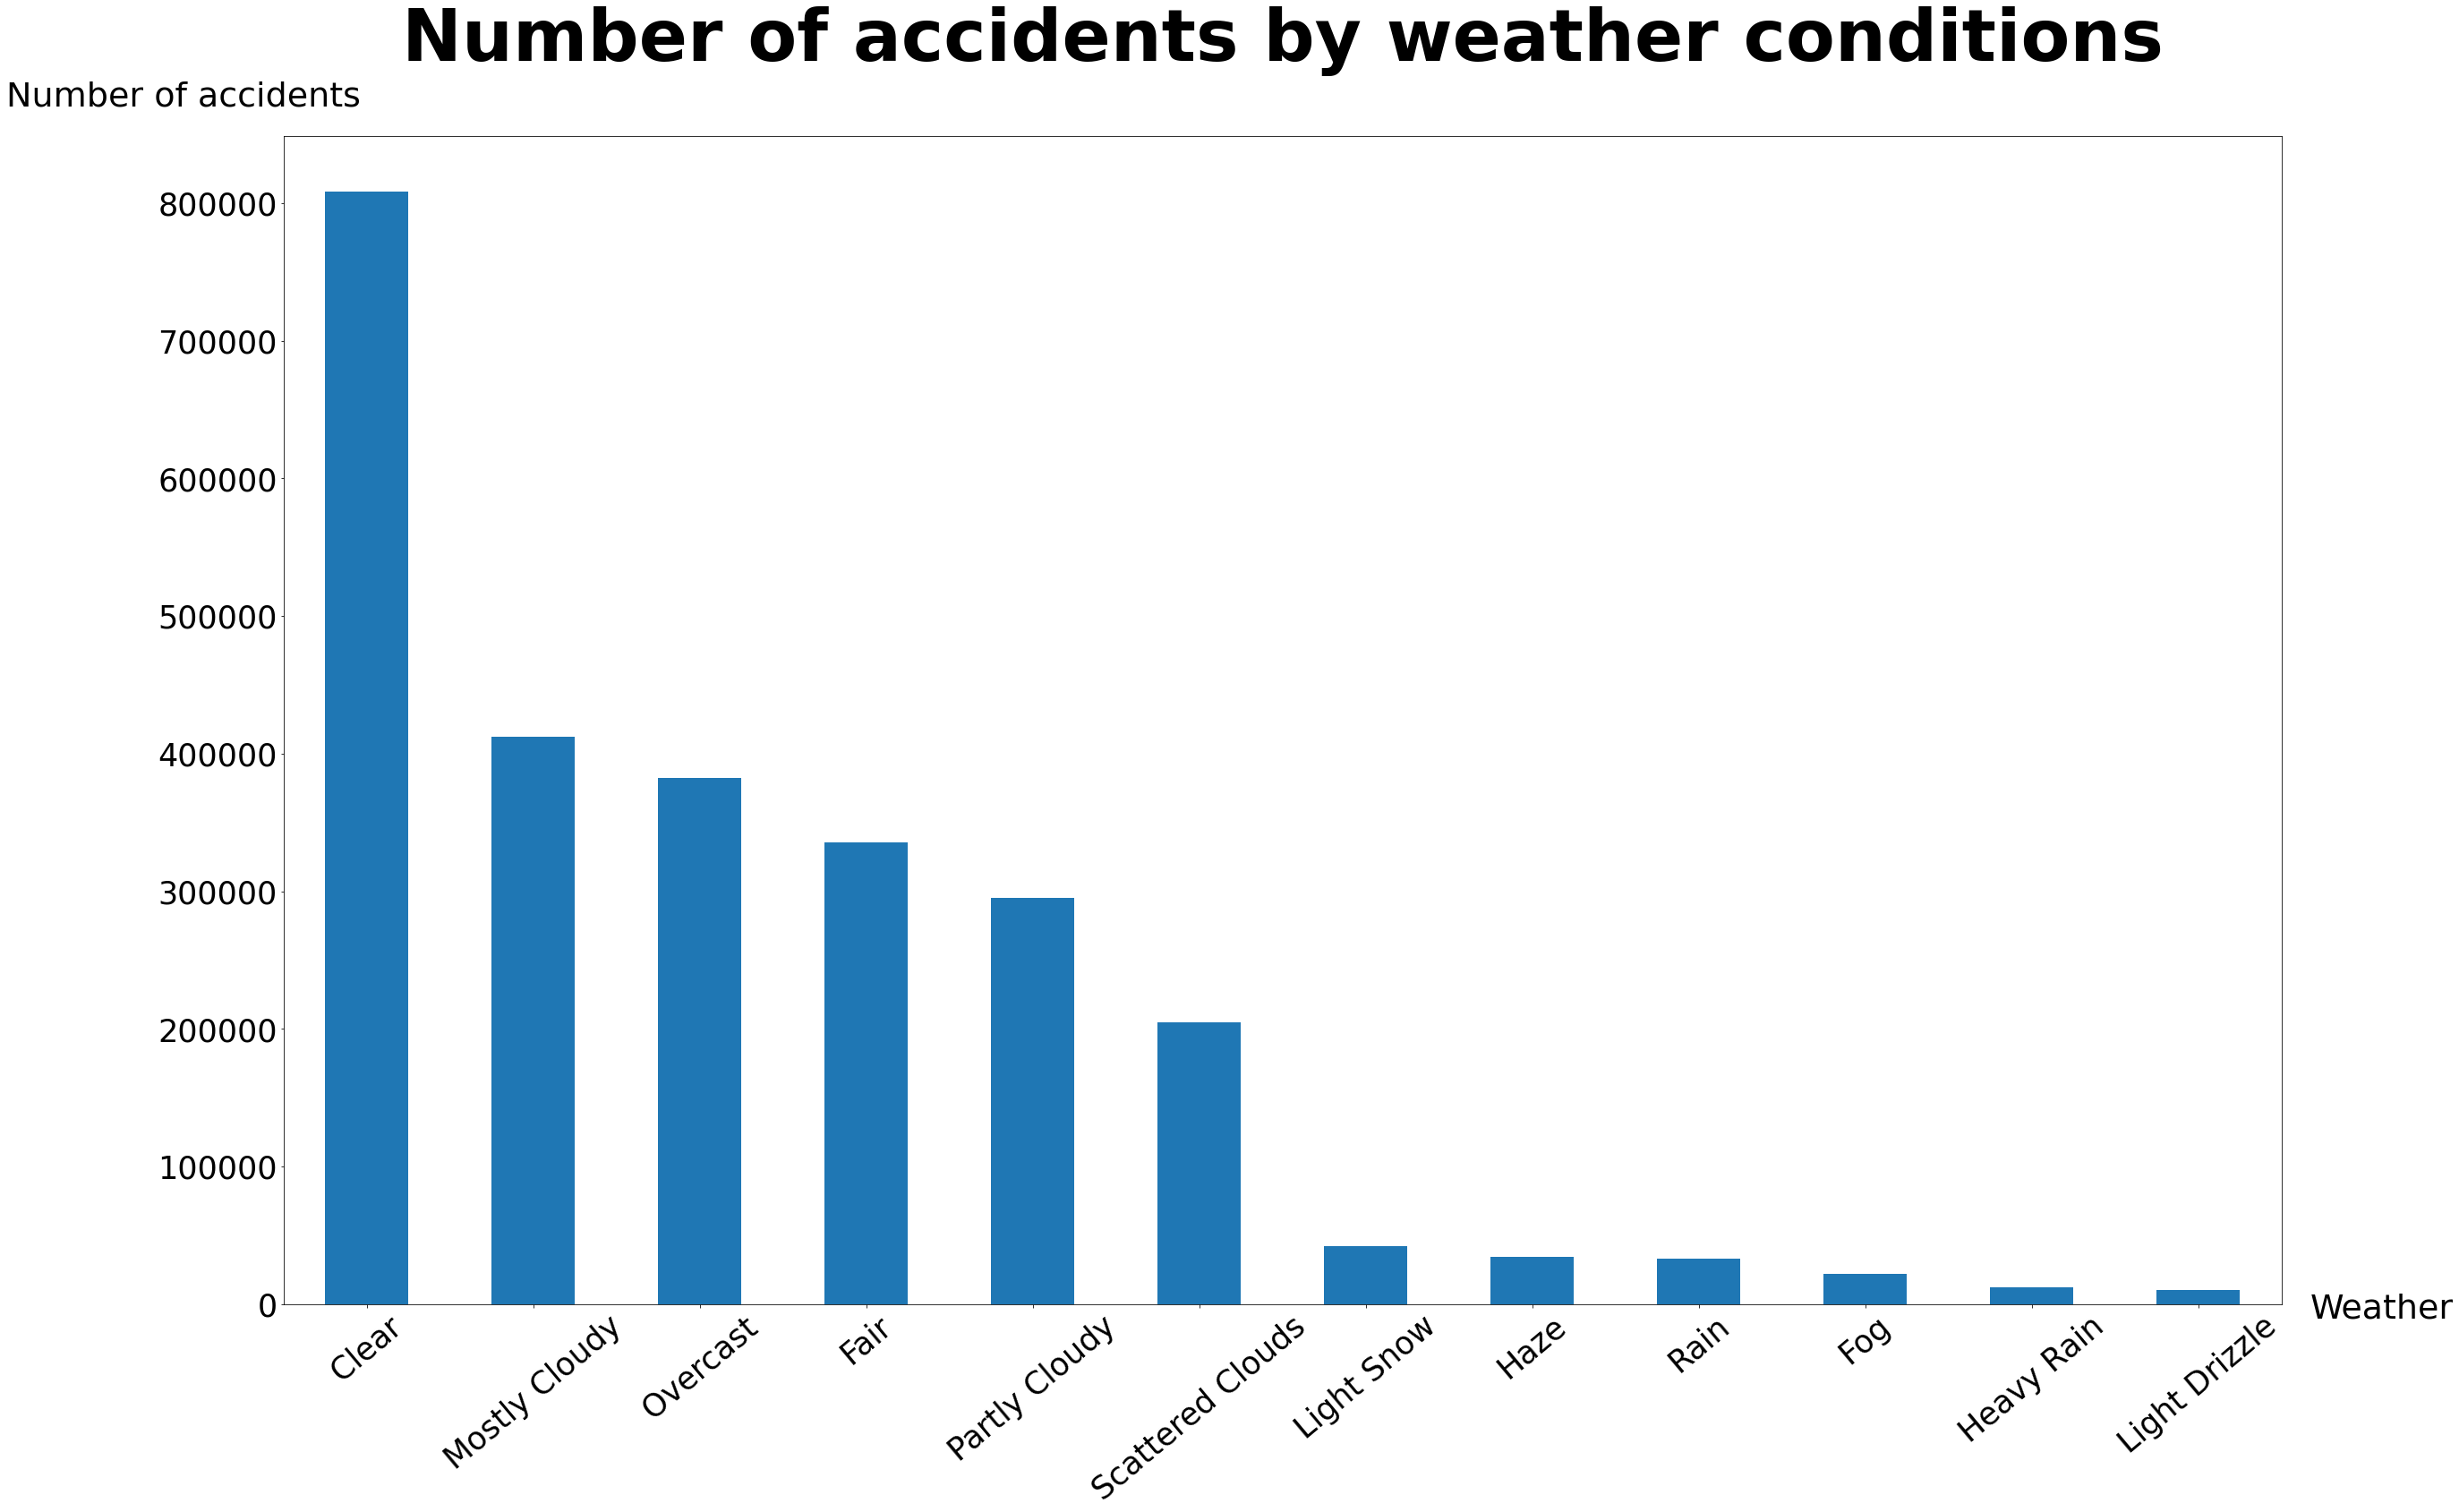

In [3]:
#Visulize the weather condition data through a horizontal bar plot
Weather = data.Weather_Condition.value_counts()
Weather_plt=Weather[['Clear','Mostly Cloudy','Overcast','Fair','Partly Cloudy','Scattered Clouds','Light Snow','Haze','Rain','Fog','Heavy Rain','Light Drizzle']]
plt.figure(figsize=(24, 18))
ax = Weather_plt.plot(kind="bar", rot=40, figsize=(40,24), fontsize=35, color='C0')
ax.set_xlabel("Weather", rotation = 0, fontsize=38)
ax.set_ylabel("Number of accidents", rotation = 0, fontsize=38)
ax.xaxis.set_label_coords(1.05,0.01)
ax.yaxis.set_label_coords(-0.05,1.02)
plt.title("Number of accidents by weather conditions", fontdict = {'fontsize': 80}, weight = 'bold', y=1.06)
plt.savefig('weather_US_horizontal.png', transparent=False)
plt.show()

### Analyze on general time distribution versus number of accidents

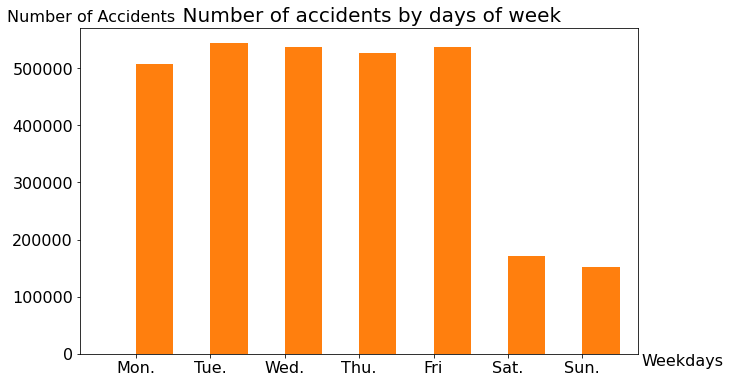

In [4]:
# use the which_day function to find the corresponding weekday
nth_day=[]
date_time=[dt for dt in data['Start_Time']]
for i in range(len(date_time)):
    nth_day.append(which_day(date_time[i]))

# add four new columns 'year', 'month', 'hour', 'weekday'
data['year'] = pd.DatetimeIndex(data['Start_Time']).year
data['month'] = pd.DatetimeIndex(data['Start_Time']).month
data['hour'] = pd.DatetimeIndex(data['Start_Time']).hour
data['weekday']=nth_day

#split data into weekdays and weekends
wday_filt = (data['weekday'].isin([0, 1, 2, 3, 4]))
weekend_filt = (data['weekday'].isin([5, 6]))
data_workday = (data.loc[wday_filt])[['hour']]
data_weekend = (data.loc[weekend_filt])[['hour']]

#plot out accidant data with respect to the weekday distribution
dt_weekday=data.groupby(['weekday'], as_index=False).count().iloc[:,:2]
ax=dt_weekday.plot(kind='bar',rot=0,width=1.0,figsize=(10, 6),fontsize=16,legend=None)
xtick_labels=['Mon.', 'Tue.', 'Wed.', 'Thu.', 'Fri', 'Sat.', 'Sun.']
ax.set_xticks(list(dt_weekday.index))
ax.set_xticklabels(xtick_labels)
ax.set_xlabel('Weekdays',rotation=0, fontsize=16)
ax.set_ylabel('Number of Accidents',rotation=0, fontsize=16)
ax.set_title('    Number of accidents by days of week', fontsize=20)
ax.xaxis.set_label_coords(1.08,0.00)
ax.yaxis.set_label_coords(0.02,1.01)
plt.savefig('#Accidents_days_of_week.png',transparent=False)
plt.show()

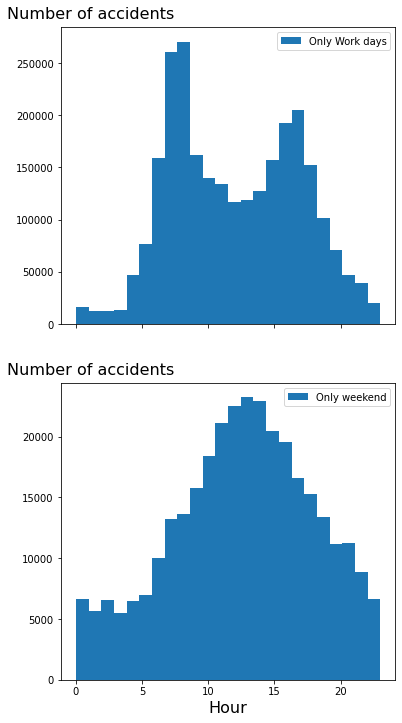

In [5]:
#plot out distributon divided into weekdays and weekends
fig,axes=plt.subplots(nrows=2,ncols=1,figsize=(6, 12),sharex=True)
ax0,ax1=axes.flatten()
kwargs = dict(bins=24,density=False,histtype='stepfilled',linewidth=3)
ax0.hist(list(data_workday['hour']),**kwargs,label='Only Work days')
ax0.set_ylabel('Number of accidents',fontsize=16,rotation=0)
ax0.yaxis.set_label_coords(0.09,1.02)
ax1.hist(list(data_weekend['hour']),**kwargs,label='Only weekend')
ax1.set_ylabel('Number of accidents',fontsize=16,rotation=0)
ax1.set_xlabel('Hour',fontsize=16)
ax1.yaxis.set_label_coords(0.09,1.02)
ax0.legend(); ax1.legend()
plt.savefig('hourly_distribution_US.png',transparent=True)
plt.show()

In [6]:
df3=snw.get_highway_accidents_and_severity()

In [7]:
ax3=sns.catplot(x="Highway", y="Severity", data=df3, color='C0',
                height=6, kind="bar",ci=99)
ax3.set_ylabels(rotation=0,fontsize=12)
ax3.set_xlabels(rotation=0,fontsize=12)
plt.show()

In [8]:
ax2=sns.catplot(x="Day of Week", y="Severity", data=df3, color='orange',
                height=6, kind="bar",ci=99)
ax2.set_ylabels(rotation=0,fontsize=20,y=1.08)
ax2.set_xlabels(rotation=0,fontsize=20)
ax2.set_xticklabels(rotation=30,fontsize=15)
plt.show()

# Poverty Calculations
### Plots

In [9]:
df_pov=pc.plot_county_accident_rates('US_Accidents_Dec19.csv')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [10]:
#Plot poverty percentage vs accident per vehicle
#Number of registered vehicles from previous function
n_vehicles={'ALAMEDA': 1370115, 'ALPINE': 3264, 'AMADOR': 60090, 'BUTTE': 228105, 'CALAVERAS': 79159, 'COLUSA': 30711, 'CONTRA COSTA': 1115734, 'DEL NORTE': 28336, 'EL DORADO': 237553, 'FRESNO': 861046, 'GLENN': 38940, 'HUMBOLDT': 154008, 'IMPERIAL': 206223, 'INYO': 28500, 'KERN': 784942, 'KINGS': 119084, 'LAKE': 90898, 'LASSEN': 36631, 'LOS ANGELES': 8154560, 'MADERA': 150284, 'MARIN': 249524, 'MARIPOSA': 28989, 'MENDOCINO': 118908, 'MERCED': 244340, 'MODOC': 13763, 'MONO': 17918, 'MONTEREY': 408110, 'NAPA': 151094, 'NEVADA': 134753, 'ORANGE': 2943942, 'PLACER': 453466, 'PLUMAS': 33937, 'RIVERSIDE': 2113938, 'SACRAMENTO': 1357361, 'SAN BENITO': 69873, 'SAN BERNARDINO': 1937675, 'SAN DIEGO': 3046126, 'SAN FRANCISCO': 492336, 'SAN JOAQUIN': 707694, 'SAN LUIS OBISPO': 316758, 'SAN MATEO': 780898, 'SANTA BARBARA': 414334, 'SANTA CLARA': 1719914, 'SANTA CRUZ': 266643, 'SHASTA': 220710, 'SIERRA': 5689, 'SISKIYOU': 66278, 'SOLANO': 438507, 'SONOMA': 541806, 'STANISLAUS': 525565, 'SUTTER': 109477, 'TEHAMA': 77616, 'TRINITY': 19767, 'TULARE': 413682, 'TUOLUMNE': 80510, 'VENTURA': 828885, 'YOLO': 192840, 'YUBA': 75066}
import addfips
af=addfips.AddFIPS()
n_vehicle_fips={}
for i in range(len(n_vehicles)):
    fips=af.get_county_fips(list(n_vehicles.keys())[i], 'CA')
    n_vehicle_fips[fips]=list(n_vehicles.values())[i]
df_vehicle=pd.DataFrame({'FIPS Code':list(n_vehicle_fips.keys()),'Number of Vehicles':list(n_vehicle_fips.values())})
df_vehicle=pd.merge(df_pov,df_vehicle)
fipss=pc.count_data(pc.get_county_fips_code('US_Accidents_Dec19.csv', 17, 16))
temp_df=pd.DataFrame({'FIPS Code':list(fipss.keys()),'Accident Total':list(fipss.values())})
df_vehicle=pd.merge(df_vehicle,temp_df)
df_vehicle['Accident per Vehicle']=df_vehicle.apply(lambda df:df['Accident Total']/df['Number of Vehicles'],axis=1)
poverty_scatter=sns.regplot('Poverty Percent, All Ages','Accident per Vehicle',data=df_vehicle,
                           scatter_kws={'alpha':.75},line_kws={"color": "red"},ci=95,
                           label='big')
poverty_scatter.set_title('California')
poverty_scatter.set_ylabel(ylabel='Accident \n per Vehicle',rotation=0,y=1.08)
plt.show()

Text(6.675000000000004, 1.08, 'Accident \n per Vehicle')

# Analysis on US accidents with focus on California State
## Analyze the relationship between weather and severity

### Analyze on weather condition and severity distribution

In [11]:
# Focus on California state
data = data[data["State"] == "CA"]

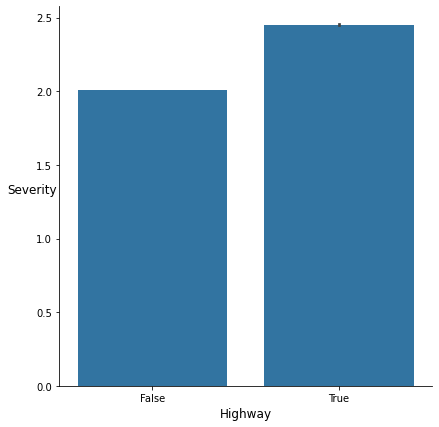

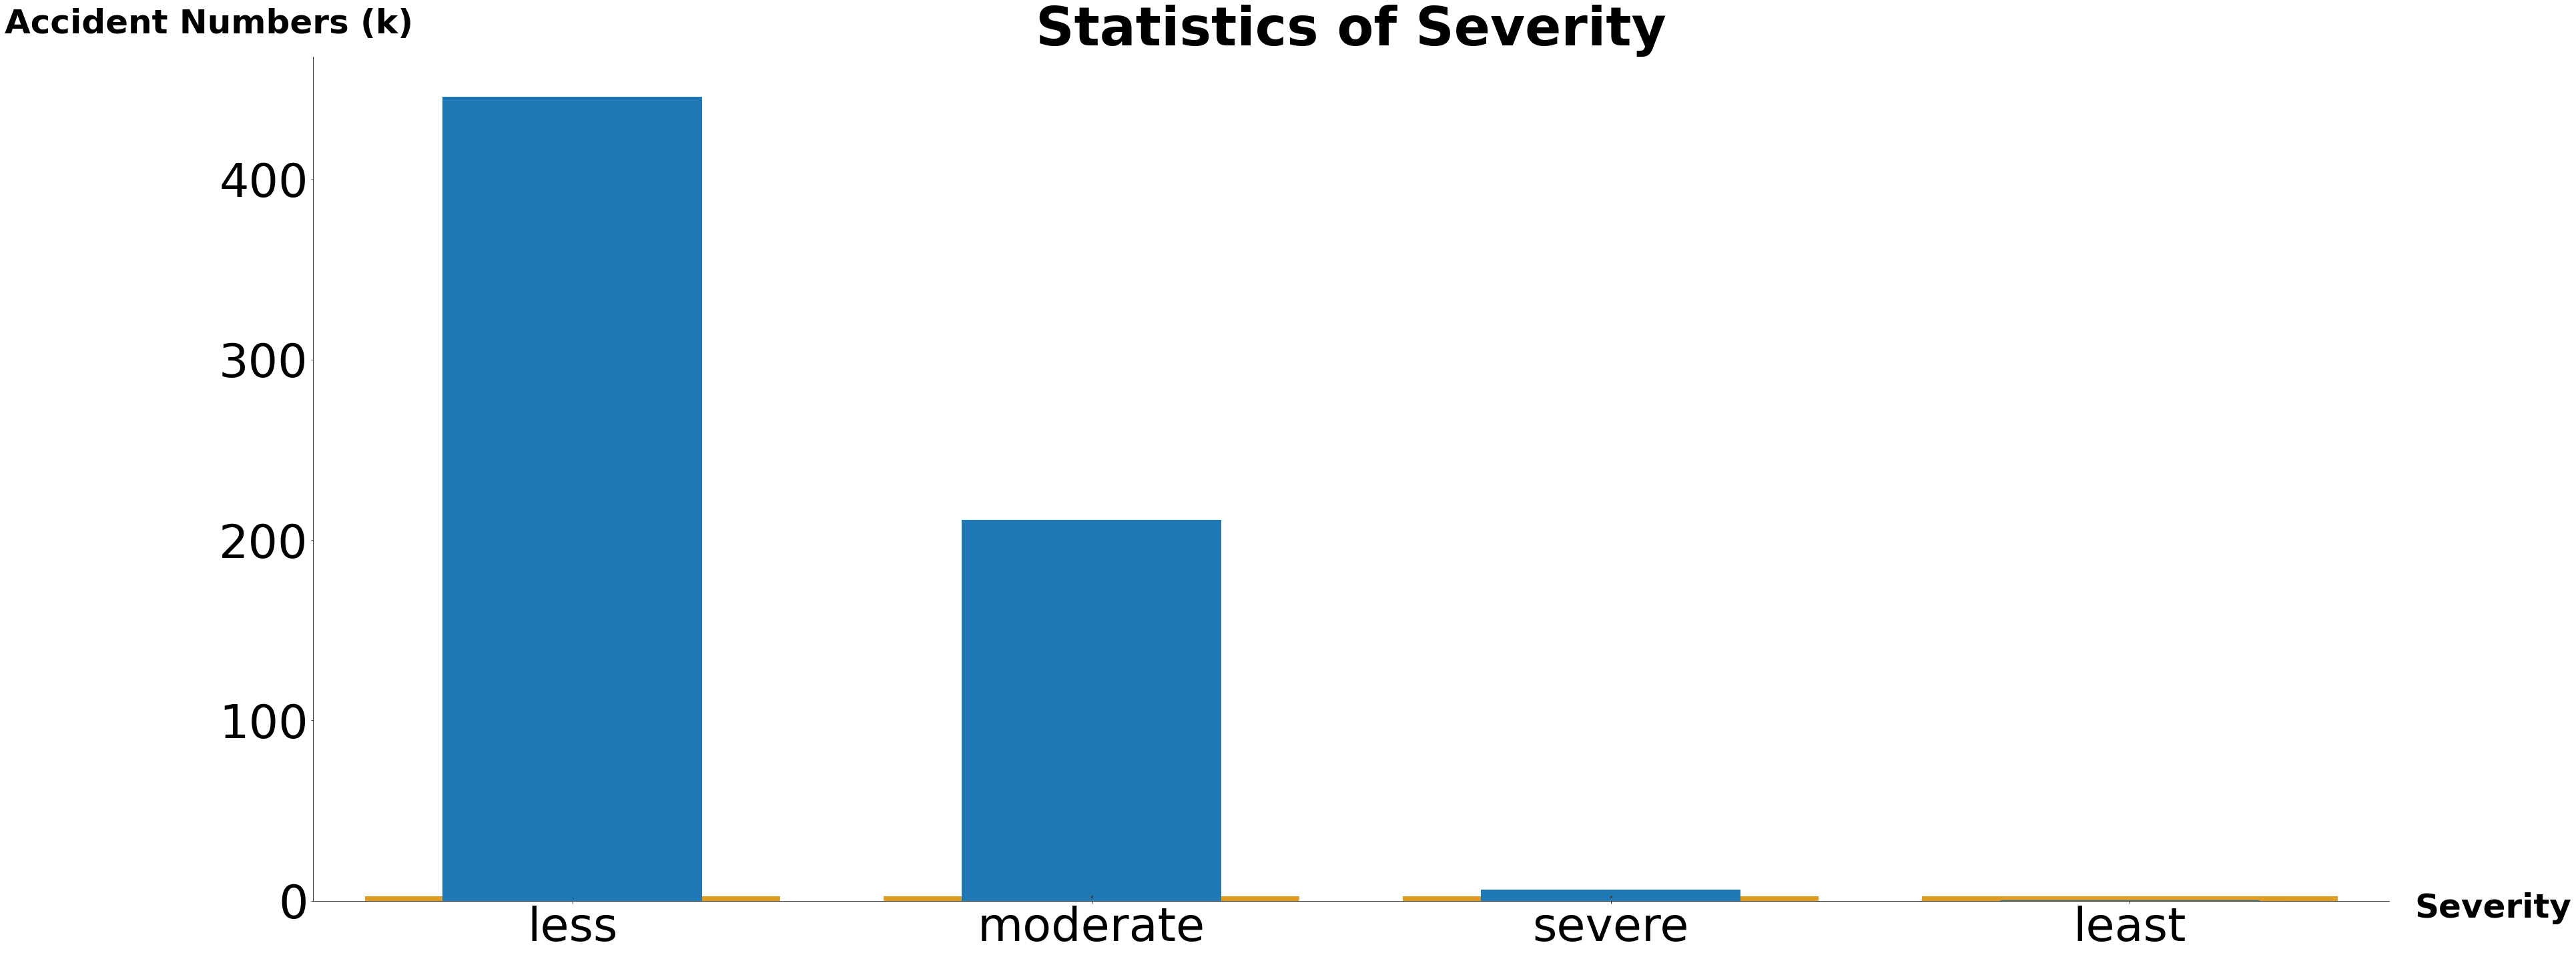

In [12]:
#Count total accident numbers under different severity
#Replace the index of "Severity" column from [1, 2, 3, 4] to ['least', 'less', 'moderate', 'severe']
#for a better understanding in plotted chart
data["Severity"] = data["Severity"].replace([1, 2, 3, 4], ['least', 'less', 'moderate', 'severe'])
severity = data["Severity"].value_counts()/1000

#Plot a bar chart of value counts under different severities
ax = severity.plot(kind="bar", rot=0, figsize=(50,20), fontsize = 70)
ax.set_xlabel("Severity", rotation = 0, fontsize=50, weight = 'bold')
ax.set_ylabel("Accident Numbers (k)", rotation = 0, fontsize=50, weight = 'bold')
ax.xaxis.set_label_coords(1.05,0.01)
ax.yaxis.set_label_coords(-0.05,1.02)
plt.title("Statistics of Severity", fontdict = {'fontsize': 80}, weight = 'bold', y=1.06)
plt.savefig("Statistics of Severity", transparent=True)
plt.show()

#Reverse the index of "Severity" column from ['least', 'less', 'moderate', 'severe'] to [1, 2, 3, 4]
data["Severity"] = data["Severity"].replace(['least', 'less', 'moderate', 'severe'], [1, 2, 3, 4])

In [13]:
#Choose desired weather condition
weather_choosed = ['Blowing Dust', 'Blowing Dust / Windy', 'Blowing Sand', 'Clear', 'Fair', 'Fog / Windy', 
                        'Hail', 'Heavy Drizzle', 'Light Freezing Rain', 'Light Rain', 'Light Snow / Windy', 
                        'Light Snow Showers', 'Mostly Cloudy', 'Thunderstorm', 'Widespread Dust / Windy']

In [14]:
#Get the dataframe of different severity percentage under each selected weather condition 
weather_severity_percentage = create_weather_severity_df(data, weather_choosed)

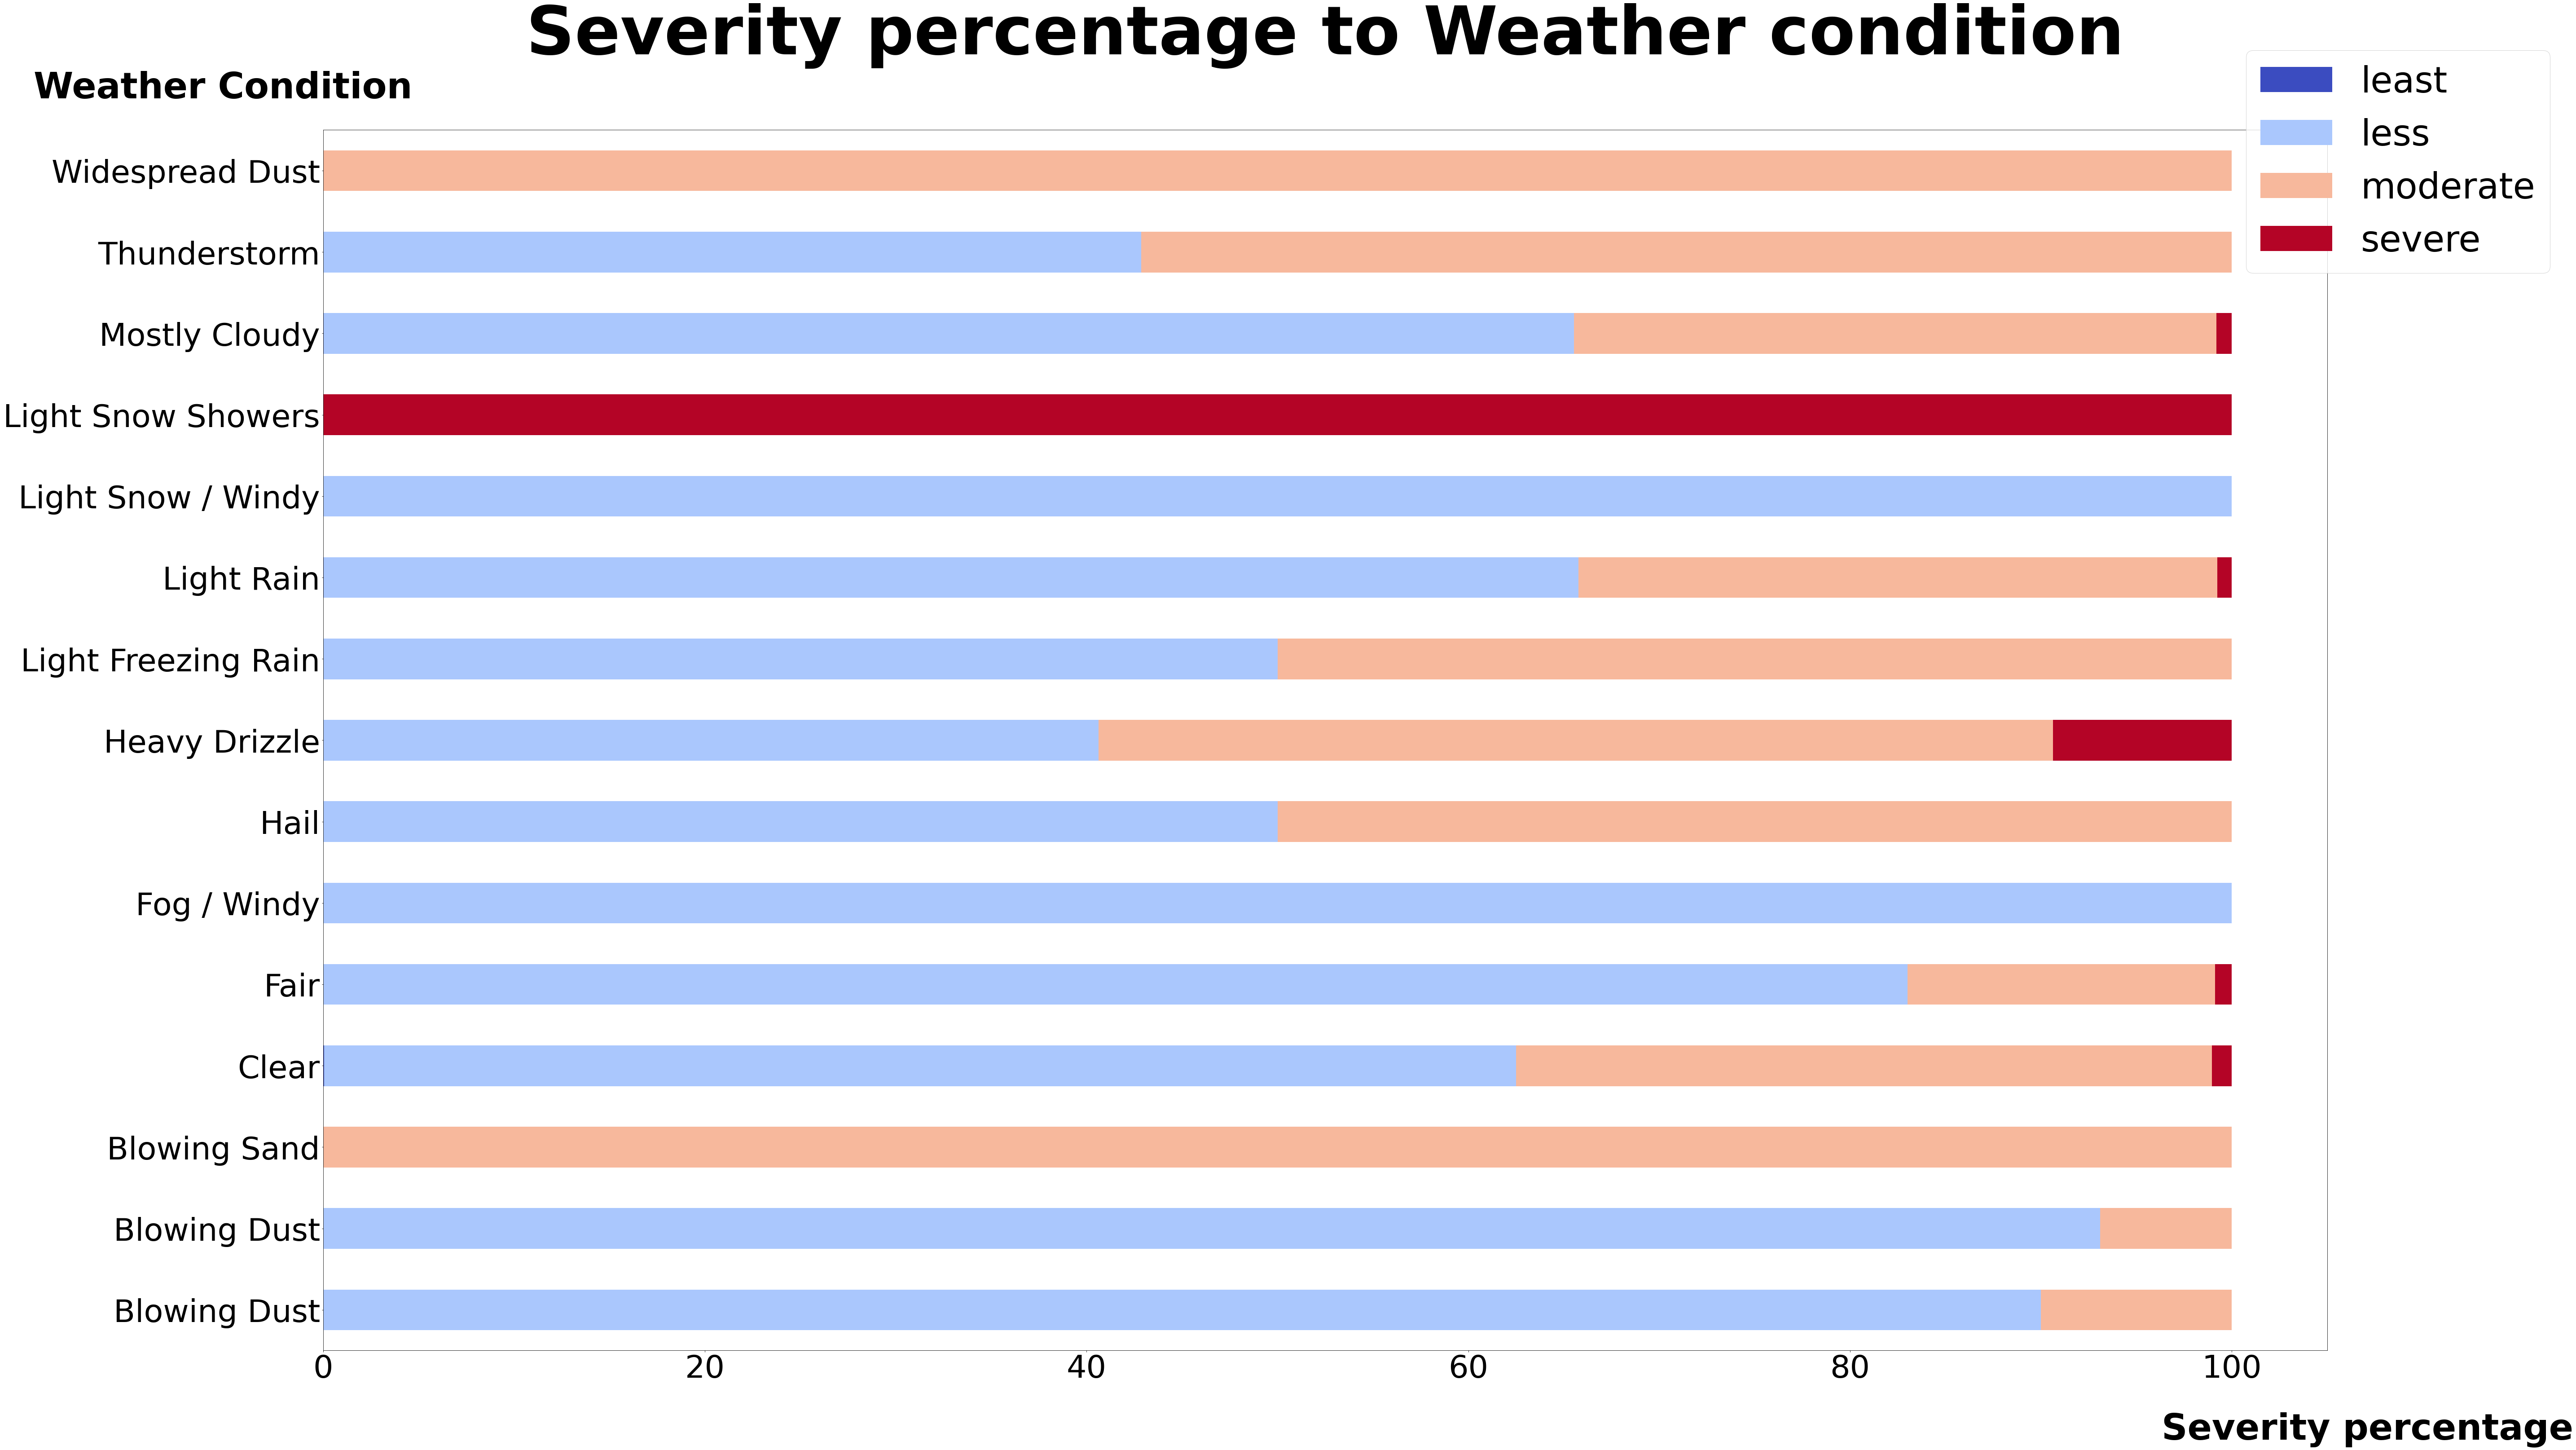

In [15]:
#Plot the stacked bar chart with percentage dataframe which are calculated above
ax = weather_severity_percentage.plot(kind="barh", stacked=True, rot=0, figsize=(80,50), fontsize=70, cmap="coolwarm")
plt.legend(('least', 'less', 'moderate', 'severe'), fontsize = 80, loc='upper right', bbox_to_anchor=(1.12, 1.08), frameon = True)
ax.set_xlabel("Severity percentage", rotation = 0, fontsize=80, weight='bold')
ax.set_ylabel("Weather Condition", rotation = 0, fontsize=80, weight='bold')
ax.xaxis.set_label_coords(1.02, -0.05)
ax.yaxis.set_label_coords(-0.05, 1.02)
plt.title("Severity percentage to Weather condition", fontdict = {'fontsize': 150}, weight='bold', y=1.06)
plt.savefig("Severity percentage to Weather condition", transparent=True)
plt.show()

### Analyze California's counties' densities

In [16]:
#Separate CA data from US data
get_cali_data('US_Accidents_Dec19.csv')

In [17]:
#get population of each county
population = get_population_CA()

In [18]:
#get number of vehicles of each county
n_vehicles = get_n_vehicles_CA()

In [19]:
#get area of each county
area = get_area_CA()

In [20]:
#get number of accidents in each county
n_accidents = get_n_accidents_CA()

In [21]:
#categorize small samples to 'others', get population, number of vehicles and number of accidents per sq mi
population_per,n_vehicles_per,n_accidents_per = data_process_CA(population,n_vehicles,area,n_accidents)

{'SAN BERNARDINO': 20056.92, 'RIVERSIDE': 7206.47, 'SAN DIEGO': 4206.63, 'LOS ANGELES': 4057.88, 'SANTA CLARA': 1290.1, 'SACRAMENTO': 964.64, 'ORANGE': 790.57, 'ALAMEDA': 739.02, 'CONTRA COSTA': 715.94, 'SAN MATEO': 448.41, 'OTHERS': 115302.51}


In [22]:
#plot
labels = []
population_plot = []
n_vehicles_plot =[]
n_accidents_plot =[]

for key,value in population_per.items():
    labels.append(key)
    population_plot.append(value)
    n_vehicles_plot.append(n_vehicles_per[key])
    n_accidents_plot.append(n_accidents_per[key])



/Users/User/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



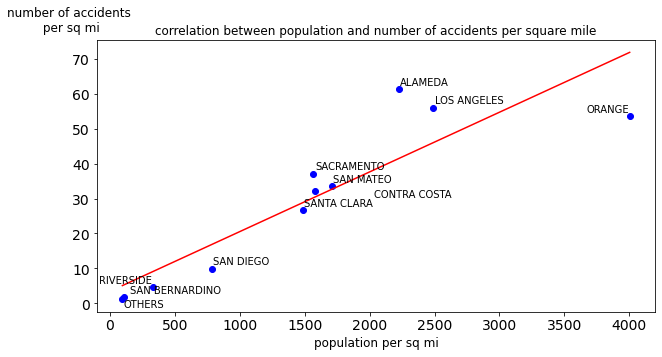

In [23]:
#get scatter plot
fig1 = plt.figure(figsize = (10,5))
texts =[]
for i,county in enumerate(labels):
    x = population_plot[i]
    y = n_accidents_plot[i]
    plt.scatter(x,y,marker = 'o',color = 'blue')
    texts.append(plt.text(x+0.3,y+0.3,county,fontsize = 10))


adjust_text(texts)
coeff1 = np.polyfit(population_plot,n_accidents_plot,1)
poly1d_fn = np.poly1d(coeff1)
plt.plot(population_plot,poly1d_fn(population_plot),'-',color = 'red')
plt.tick_params(axis="both", labelsize=14)
ax = plt.axes()
ax.yaxis.set_label_coords(-0.05,1.02)
plt.title('correlation between population and number of accidents per square mile',fontsize = 12)
plt.xlabel('population per sq mi',fontsize = 12)
plt.ylabel('number of accidents\n per sq mi',fontsize = 12,rotation = 0)

fig1.savefig('pop.png', transparent=True)
plt.show()


/Users/User/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



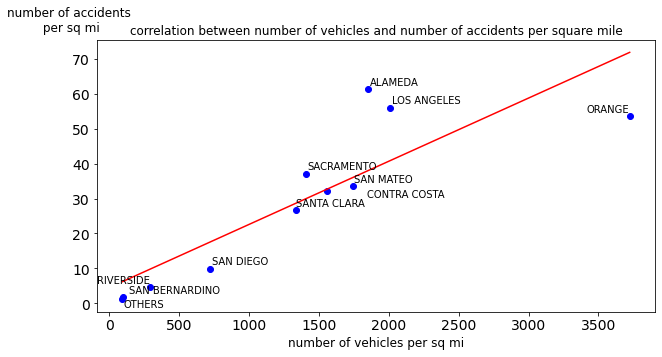

In [24]:
#get scatter plot
fig2 = plt.figure(figsize = (10,5))
texts =[]
for i,county in enumerate(labels):
    x = n_vehicles_plot[i]
    y = n_accidents_plot[i]
    plt.scatter(x,y,marker = 'o',color = 'blue')
    texts.append(plt.text(x+0.3,y+0.3,county,fontsize = 10))

adjust_text(texts)
coeff2 = np.polyfit(n_vehicles_plot,n_accidents_plot,1)
poly1d_fn2 = np.poly1d(coeff2)
plt.plot(n_vehicles_plot,poly1d_fn2(n_vehicles_plot),'-',color = 'red')

plt.tick_params(axis="both", labelsize=14)
ax = plt.axes()
ax.yaxis.set_label_coords(-0.05,1.02)
plt.title('correlation between number of vehicles and number of accidents per square mile',fontsize = 12)
plt.xlabel('number of vehicles per sq mi',fontsize = 12)
plt.ylabel('number of accidents\n per sq mi',fontsize = 12,rotation = 0)
fig2.savefig('vehicle.png', transparent=True)
plt.show()